In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%cd ..

/mnt/d/anomaly-detection


In [3]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [4]:
window_length = 64
stride = 0

X = np.array([
    data.iloc[i - window_length:i].to_numpy().flatten()
    for i in range(window_length, data.shape[0] - window_length - stride)
]).reshape(-1, window_length, data.shape[1])

In [5]:
from src.models.autoencoder import build_autoencoder
import keras

build_params = dict(
    input_shape=window_length,
    layers_size=[16, window_length],
    optimizer=keras.optimizers.Adam(lr=0.01),
    reg_strength=0.005,
)

fit_params = dict(
    batch_size=64,
    epochs=10,
    verbose=1,
    callbacks=[keras.callbacks.ReduceLROnPlateau()]
)

model_fn = lambda: build_autoencoder(**build_params)

Using TensorFlow backend.


In [6]:
from sklearn.model_selection import TimeSeriesSplit

tssplit = TimeSeriesSplit(n_splits=3)
results = []

for i, (train_idx, test_idx) in enumerate(tssplit.split(X, X)):
    print(f'Fold {i}...')
    model = model_fn()
    
    history = model.fit(X[train_idx, :, 0],
                        X[train_idx, :, 0],
                        validation_data=(X[test_idx, :, 0], X[test_idx, :, 0]),
                        **fit_params)
    results.append(history.history)

W0909 20:49:45.375897 140288693962560 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 20:49:45.378879 140288693962560 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 20:49:45.384018 140288693962560 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 20:49:45.430367 140288693962560 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Fold 0...


W0909 20:49:45.668324 140288693962560 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0909 20:49:45.744755 140288693962560 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 3169 samples, validate on 3168 samples
Epoch 1/10
3169/3169 [==============================] - 0s 103us/step - loss: 0.3918 - val_loss: 0.2029
Epoch 2/10
3169/3169 [==============================] - 0s 24us/step - loss: 0.1286 - val_loss: 0.0929
Epoch 3/10
3169/3169 [==============================] - 0s 21us/step - loss: 0.0802 - val_loss: 0.0712
Epoch 4/10
3169/3169 [==============================] - 0s 20us/step - loss: 0.0665 - val_loss: 0.0713
Epoch 5/10
3169/3169 [==============================] - 0s 19us/step - loss: 0.0580 - val_loss: 0.0548
Epoch 6/10
3169/3169 [==============================] - 0s 19us/step - loss: 0.0558 - val_loss: 0.0553
Epoch 7/10
3169/3169 [==============================] - 0s 19us/step - loss: 0.0520 - val_loss: 0.0554
Epoch 8/10
3169/3169 [==============================] - 0s 18us/step - loss: 0.0515 - val_loss: 0.0491
Epoch 9/10
3169/3169 [==============================] - 0s 18us/step - loss: 0.0498 - val_loss: 0.0546
Epoch 10/10
3169/3169 [=

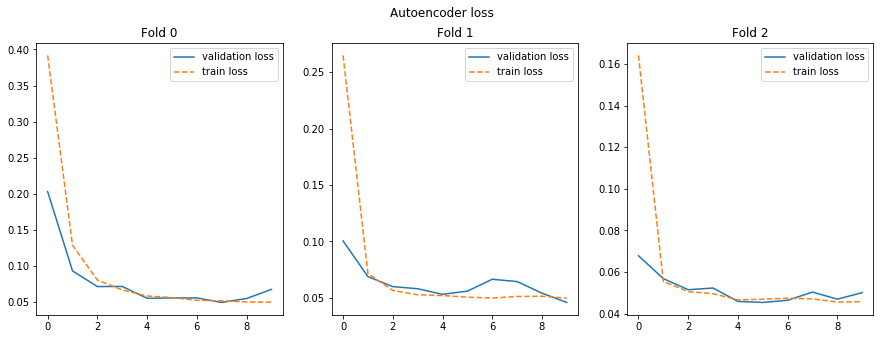

In [7]:
from src.visualization.visualize import visualize_result
visualize_result(results, f'Autoencoder loss')

It works, so lets train on all data.

In [8]:
model = model_fn()
model.fit(X[:, :, 0], X[:, :, 0], **fit_params)

Epoch 1/10
12673/12673 [==============================] - 0s 35us/step - loss: 0.1631
Epoch 2/10
 8896/12673 [====================>.........] - ETA: 0s - loss: 0.0626

/home/elch10/miniconda3/lib/python3.7/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


12673/12673 [==============================] - 0s 17us/step - loss: 0.0581
Epoch 3/10
12673/12673 [==============================] - 0s 15us/step - loss: 0.0490
Epoch 4/10
12673/12673 [==============================] - 0s 14us/step - loss: 0.0495
Epoch 5/10
12673/12673 [==============================] - 0s 15us/step - loss: 0.0458
Epoch 6/10
12673/12673 [==============================] - 0s 14us/step - loss: 0.0460
Epoch 7/10
12673/12673 [==============================] - 0s 14us/step - loss: 0.0456
Epoch 8/10
12673/12673 [==============================] - 0s 14us/step - loss: 0.0472
Epoch 9/10
12673/12673 [==============================] - 0s 14us/step - loss: 0.0448
Epoch 10/10
12673/12673 [==============================] - 0s 14us/step - loss: 0.0493


In [9]:
model.save('models/onedimensional_autoencoder.h5')

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                1088      
Total params: 2,128
Trainable params: 2,128
Non-trainable params: 0
_________________________________________________________________


## Extract first layer that can embedes data

In [13]:
import keras
from keras.layers import Input
from keras.models import Model

In [16]:
inp = Input(shape=(window_length,))
encoder_layer = model.layers[0]
encoded = encoder_layer(inp)

encoder = Model(inputs=inp, outputs=encoded)

In [20]:
predictions = encoder.predict(X[:, :, 0])

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X[:, :, 0])
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]

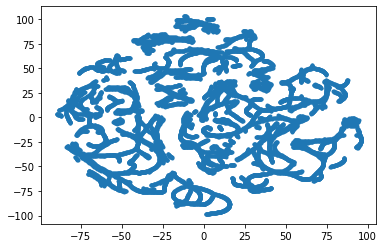

In [23]:
plt.scatter(vis_x, vis_y, marker='.')

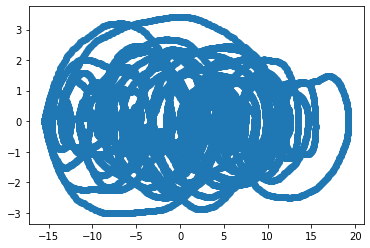

In [24]:
from sklearn.decomposition import PCA

X_embedded = PCA(n_components=2).fit_transform(X[:, :, 0])
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]
plt.scatter(vis_x, vis_y)

In [ ]:
# from MulticoreTSNE import MulticoreTSNE as TSNE

# embeddings = TSNE(n_jobs=4).fit_transform(predictions)
# vis_x = embeddings[:, 0]
# vis_y = embeddings[:, 1]
# plt.scatter(vis_x, vis_y, c=digits.target, cmap=plt.cm.get_cmap("jet", 10), marker='.')
# plt.colorbar(ticks=range(10))
# plt.clim(-0.5, 9.5)